<a href="https://colab.research.google.com/github/CastleJH/Music-To-Dance/blob/main/Music_To_Dance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torchaudio.transforms as transforms
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#멜스펙트로그램. time과 freq가 transpose되어 나옴.
def AudioToMelSpectrogram(waveform, sample_rate, target_frame=900):
  if waveform.size(0) > 1:
    waveform = waveform.mean(dim = 0)

  assert waveform.dim() == 1

  n_fft = (waveform.size(0) // target_frame) * 2
  mel_spec = transforms.MelSpectrogram(sample_rate=sample_rate, n_fft = n_fft)(waveform)

  assert mel_spec.size(1) >= target_frame

  mel_spec = mel_spec[:, :target_frame]
  mel_spec_db = transforms.AmplitudeToDB()(mel_spec)
  mel_spec_db = torch.transpose(mel_spec_db, 0, 1)

  return mel_spec_db

In [ ]:
#데이터셋
class MusicDanceDataset(Dataset):
  def __init__(self, music_data_path, dance_data_path, num_keyframe):
    self.music_data_path = music_data_path
    self.dance_data_path = dance_data_path
    self.num_keyframe = num_keyframe
    self.music_data, self.dance_data = self.PreprocessData()

  # 데이터 준비
  def PreprocessData(self):
    file_list = os.listdir(self.dance_data_path)
    dance_data = []
    tmp_dance_data = []
    music_data = []

    minFrameNum = 10000000

    minX = 100000000
    maxX = 0
    minY = 100000000
    maxY = 0

    #각 파일 읽기
    for file_name in file_list:
      dance_file_path = os.path.join(self.dance_data_path, file_name)
      with open(dance_file_path, 'rb') as file:
        data = pickle.load(file)

      # 0번 카메라의 키포인트 데이터 가져오기
      tmp_result = []
      for seq in range(len(data["keypoints2d"][0])):
        one_seq = []
        for keypoint in range(len(data["keypoints2d"][0][0])):
          one_seq.append(float(data["keypoints2d"][0][seq][keypoint][0]))
          minX = min(minX, float(data["keypoints2d"][0][seq][keypoint][0]))
          maxX = max(maxX, float(data["keypoints2d"][0][seq][keypoint][0]))
          one_seq.append(float(data["keypoints2d"][0][seq][keypoint][1]))
          minY = min(minY, float(data["keypoints2d"][0][seq][keypoint][1]))
          maxY = max(maxY, float(data["keypoints2d"][0][seq][keypoint][1]))
        tmp_result.append(one_seq)
      tmp_dance_data.append(tmp_result)

    # 0~1 사이로 축소
    for data in tmp_dance_data:
      real_result = []
      for seq in data:
        tmp_seq = []
        for idx in range(self.num_keyframe // 2):
          tmp_seq.append((seq[idx * 2] - minX) / (maxX - minX))
          tmp_seq.append((seq[idx * 2 + 1] - minY) / (maxY - minY))
        real_result.append(tmp_seq)
      dance_data.append(real_result)

      #길이 맞나 확인
      num_frames = len(real_result)
      minFrameNum = min(minFrameNum, num_frames)
      assert len(real_result[0]) == self.num_keyframe

      #멜스펙트로그램으로 변환
      music_file_name = file_name.split('.')[0]+'.wav'
      music_file_path = os.path.join(self.music_data_path, music_file_name)

      waveform, sample_rate = torchaudio.load(music_file_path)
      mel_spectrogram_db = AudioToMelSpectrogram(waveform, sample_rate, num_frames)
      music_data.append(mel_spectrogram_db)

    ret_dance_data = []
    for seq in dance_data:
      seq = seq[:minFrameNum]
      ret_dance_data.append(seq)
    ret_music_data = []
    for seq in music_data:
      seq = seq[:minFrameNum, :]
      ret_music_data.append(seq)

    dance_data = torch.tensor(ret_dance_data)
    music_data = torch.stack(ret_music_data)
    return music_data, dance_data

  def __len__(self):
      return len(self.music_data)

  def __getitem__(self, index):
      music_sample = self.music_data[index]
      dance_sample = self.dance_data[index]
      return music_sample, dance_sample

In [ ]:
mel_freq_size = 128
hidden_size = 256
num_keyframes = 34
learning_rate = 0.001
num_epochs = 50
batch_size = 8

# 데이터셋
dataset = MusicDanceDataset("/content/drive/MyDrive/Data/AIST_Audio", "/content/drive/MyDrive/Data/AIST_pkl", num_keyframes)

# Train, Valid, Test 데이터로더
train_data, val_data = train_test_split(dataset, test_size=0.15)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [ ]:
class MusicToDanceModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MusicToDanceModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fcs = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(hidden_size, hidden_size * 2),
            nn.Sigmoid(),
            nn.Dropout(0.25),
            nn.Linear(hidden_size * 2, output_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, _ = self.rnn(x, hidden)
        out = self.fcs(out)
        return out

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

In [ ]:
print(dataset.music_data)
print(dataset.dance_data)

tensor([[[ 21.3650,  25.8131,  16.9368,  ..., -14.2369, -16.2971, -18.3349],
         [ 40.2842,  45.5567,  50.9740,  ..., -11.8898, -13.9639, -15.6450],
         [ 34.1519,  58.1995,  60.0658,  ..., -24.5175, -24.3936, -26.2053],
         ...,
         [ 35.5086,  56.2832,  56.7466,  ..., -27.2616, -27.9616, -25.3058],
         [ 38.1227,  60.4746,  58.2811,  ..., -38.2483, -39.1355, -38.5390],
         [ 37.8443,  60.5185,  57.5330,  ..., -26.3644, -27.5620, -25.8991]],

        [[ 27.6568,  28.0836,  28.4372,  ..., -11.9497, -14.1104, -16.1214],
         [ 41.1507,  50.0828,  55.1638,  ..., -12.5564, -14.4924, -16.1223],
         [ 38.9976,  59.0809,  59.7789,  ..., -23.6137, -23.1834, -24.2725],
         ...,
         [ 21.7094,  36.4449,  39.8366,  ..., -15.3820, -15.1801, -14.5263],
         [ 37.3248,  43.5391,  52.0472,  ..., -16.9947, -16.7204, -15.3717],
         [ 37.3562,  58.1267,  59.6744,  ..., -20.2875, -19.9658, -20.0891]],

        [[ 31.1033,  31.5753,  30.8803,  ...

In [ ]:
# 모델
model = MusicToDanceModel(mel_freq_size, hidden_size, num_keyframes)

# loss
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    model.train()
    tot_loss = 0
    for music, dance in train_loader:
        output = model(music)

        loss = criterion(output, dance)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        tot_loss += loss.item()
    avg_loss = tot_loss / len(train_loader)
    train_loss.append(avg_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for music, dance in val_loader:
            output = model(music)
            val_loss += criterion(output, dance).item()

    avg_val_loss = val_loss / len(val_loader)
    valid_loss.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

Epoch [1/50], Train Loss: 0.0159, Validation Loss: 0.0055
Epoch [2/50], Train Loss: 0.0053, Validation Loss: 0.0051
Epoch [3/50], Train Loss: 0.0045, Validation Loss: 0.0048
Epoch [4/50], Train Loss: 0.0037, Validation Loss: 0.0041
Epoch [5/50], Train Loss: 0.0036, Validation Loss: 0.0040
Epoch [6/50], Train Loss: 0.0033, Validation Loss: 0.0040
Epoch [7/50], Train Loss: 0.0031, Validation Loss: 0.0039
Epoch [8/50], Train Loss: 0.0032, Validation Loss: 0.0040
Epoch [9/50], Train Loss: 0.0030, Validation Loss: 0.0039
Epoch [10/50], Train Loss: 0.0029, Validation Loss: 0.0039
Epoch [11/50], Train Loss: 0.0028, Validation Loss: 0.0039
Epoch [12/50], Train Loss: 0.0032, Validation Loss: 0.0038
Epoch [13/50], Train Loss: 0.0029, Validation Loss: 0.0039
Epoch [14/50], Train Loss: 0.0027, Validation Loss: 0.0038
Epoch [15/50], Train Loss: 0.0027, Validation Loss: 0.0038
Epoch [16/50], Train Loss: 0.0027, Validation Loss: 0.0039
Epoch [17/50], Train Loss: 0.0028, Validation Loss: 0.0038
Epoch 

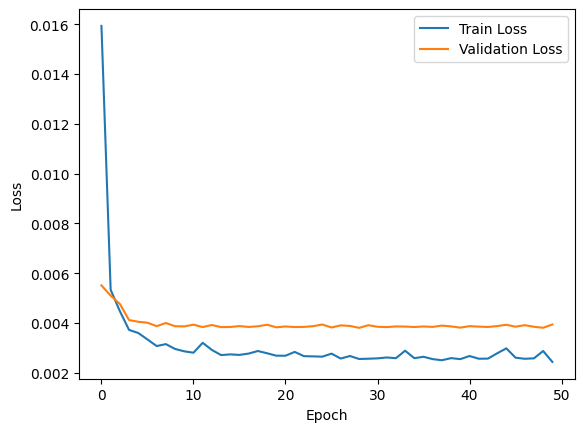

In [ ]:
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model, f'epoch{num_epochs}.pth')

In [ ]:
music_name = "mBR0"

In [ ]:
file_path = f"/content/drive/MyDrive/Data/AIST_Audio/{music_name}.wav"
waveform, sample_rate = torchaudio.load(file_path)
data = AudioToMelSpectrogram(waveform, sample_rate, 450).unsqueeze(0)

result = model(data)

file_path = f"model_output_{music_name}_{num_epochs}.txt"
with open(file_path, 'w') as file:
  for seq in result[0]:
    for val in seq:
      message = "{:.4f} ".format(val)
      file.write(message)
    file.write("\n")